# This notebook is further EDA and modeling - sticking with the ternary values

### Our metric is 

In [96]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#additional EDA
from pandas_profiling import ProfileReport

# Model selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report

# Ensemble/XGBoost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Visualizing
from sklearn.tree import export_graphviz
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from sklearn.tree import plot_tree

### I've avoided it long enough, but it's time to make some functions to speed things up in the long run.

In [80]:
#reading in the data 
values_df = pd.read_csv('../../notebooks/training_set_values', index_col=0)
labels_df = pd.read_csv('../../notebooks/training_set_labels', index_col=0)

df = pd.merge(labels_df, values_df, on=['id'])

df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [81]:
st_df = df[['status_group','source_type', 'extraction_type', 'waterpoint_type', 
            'basin', 'quality_group', 'quantity_group']]
st_df.head()

,status_group,source_type,extraction_type,waterpoint_type,basin,quality_group,quantity_group
0,functional,spring,gravity,communal standpipe,Lake Nyasa,good,enough
1,functional,rainwater harvesting,gravity,communal standpipe,Lake Victoria,good,insufficient
2,functional,dam,gravity,communal standpipe multiple,Pangani,good,enough
3,non functional,borehole,submersible,communal standpipe multiple,Ruvuma / Southern Coast,good,dry
4,functional,rainwater harvesting,gravity,communal standpipe,Lake Victoria,good,seasonal


In [82]:
# identify target and features
# target variable
y = st_df['status_group']
# features
X = st_df.drop('status_group', axis=1)

In [83]:
# time for a train test split and a new model or two

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

In [84]:
#encode the categoricals
ohe = OneHotEncoder(drop='first')

ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()

# Creating this DataFrame is not necessary its only to show the result of the ohe
ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))

ohe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47520 entries, 0 to 47519
Data columns (total 46 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   source_type_dam                              47520 non-null  float64
 1   source_type_other                            47520 non-null  float64
 2   source_type_rainwater harvesting             47520 non-null  float64
 3   source_type_river/lake                       47520 non-null  float64
 4   source_type_shallow well                     47520 non-null  float64
 5   source_type_spring                           47520 non-null  float64
 6   extraction_type_cemo                         47520 non-null  float64
 7   extraction_type_climax                       47520 non-null  float64
 8   extraction_type_gravity                      47520 non-null  float64
 9   extraction_type_india mark ii                47520 non-null  float64
 10

### starting with a decision tree

In [85]:
# going to fit a simple decision tree
clf = DecisionTreeClassifier(max_depth=3, random_state=42)

clf.fit(X_train_ohe, y_train)

for col, feature in zip(ohe_df.columns, clf.feature_importances_):
    print(col, feature)

source_type_dam 0.0
source_type_other 0.0
source_type_rainwater harvesting 0.008678767328624345
source_type_river/lake 0.0
source_type_shallow well 0.0
source_type_spring 0.022003220947391353
extraction_type_cemo 0.0
extraction_type_climax 0.0
extraction_type_gravity 0.0
extraction_type_india mark ii 0.0
extraction_type_india mark iii 0.0
extraction_type_ksb 0.0
extraction_type_mono 0.0
extraction_type_nira/tanira 0.0
extraction_type_other 0.0
extraction_type_other - mkulima/shinyanga 0.0
extraction_type_other - play pump 0.0
extraction_type_other - rope pump 0.0
extraction_type_other - swn 81 0.0
extraction_type_submersible 0.0
extraction_type_swn 80 0.0
extraction_type_walimi 0.0
extraction_type_windmill 0.0
waterpoint_type_communal standpipe 0.0
waterpoint_type_communal standpipe multiple 0.07022652413413767
waterpoint_type_dam 0.0
waterpoint_type_hand pump 0.0
waterpoint_type_improved spring 0.0
waterpoint_type_other 0.4511188215659108
basin_Lake Nyasa 0.0
basin_Lake Rukwa 0.0
basi

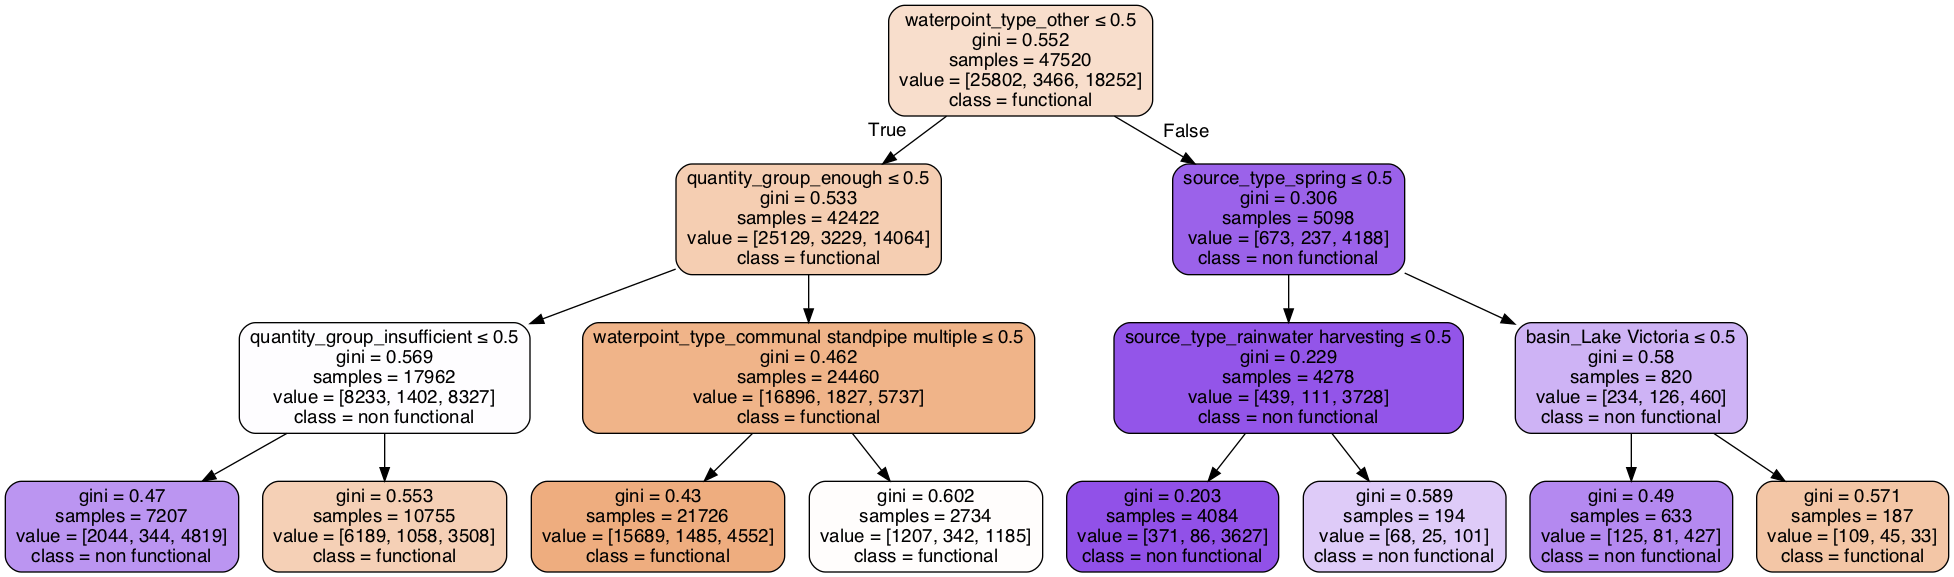

In [86]:
# Create DOT data
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=ohe_df.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [87]:
clf_preds = clf.predict(X_train_ohe)

In [108]:
def display_scores(true, preds, model_name):
    rec = recall_score(true, preds, average='micro')
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='micro')
    prec = precision_score(true, preds, average='micro', zero_division=0)
    rc = classification_report(true , preds)
    cm = confusion_matrix(true, preds)
    
    print("Model: {}".format(model_name))
    print("Recall: {}".format(rec))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    print("Precision: {}".format(prec))
    print("Classification Report:\n {}".format(rc))
    print("Confusion Matrix:\n {}".format(cm))
    print("--------------------------------------------------------------------------------")
    

    return display_scores


In [109]:
display_scores(y_train, clf_preds, model_name="Simple Tree")

Model: Simple Tree
Recall: 0.676936026936027
Accuracy: 0.676936026936027
F1-Score: 0.676936026936027
Precision: 0.676936026936027
Classification Report:
                          precision    recall  f1-score   support

             functional       0.66      0.90      0.76     25802
functional needs repair       0.00      0.00      0.00      3466
         non functional       0.74      0.49      0.59     18252

               accuracy                           0.68     47520
              macro avg       0.47      0.46      0.45     47520
           weighted avg       0.64      0.68      0.64     47520

Confusion Matrix:
 [[23194     0  2608]
 [ 2930     0   536]
 [ 9278     0  8974]]
--------------------------------------------------------------------------------


<function __main__.display_scores(true, preds, model_name)>

### Let's try some boosting

    Instantiate.

In [92]:
# Instantiate an AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=500, random_state=42)

# Instantiate a GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=500, random_state=42)

# Instantiate a RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, random_state=42)

    Fit.

In [93]:
abc.fit(X_train_ohe, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [94]:
gbc.fit(X_train_ohe, y_train)

GradientBoostingClassifier(n_estimators=500, random_state=42)

In [95]:
rfc.fit(X_train_ohe, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

    Predict.

In [97]:
abc_preds = abc.predict(X_train_ohe)
gbc_preds = gbc.predict(X_train_ohe)
rfc_preds = rfc.predict(X_train_ohe)

    Return scores.

In [110]:
display_scores(y_train, clf_preds, model_name="Simple Tree")

display_scores(y_train, abc_preds , model_name='AdaBoost')

display_scores(y_train, gbc_preds , model_name='Gradient Boost')

display_scores(y_train, rfc_preds , model_name='Random Forest')

Model: Simple Tree
Recall: 0.676936026936027
Accuracy: 0.676936026936027
F1-Score: 0.676936026936027
Precision: 0.676936026936027
Classification Report:
                          precision    recall  f1-score   support

             functional       0.66      0.90      0.76     25802
functional needs repair       0.00      0.00      0.00      3466
         non functional       0.74      0.49      0.59     18252

               accuracy                           0.68     47520
              macro avg       0.47      0.46      0.45     47520
           weighted avg       0.64      0.68      0.64     47520

Confusion Matrix:
 [[23194     0  2608]
 [ 2930     0   536]
 [ 9278     0  8974]]
--------------------------------------------------------------------------------
Model: AdaBoost
Recall: 0.7080387205387205
Accuracy: 0.7080387205387205
F1-Score: 0.7080387205387205
Precision: 0.7080387205387205
Classification Report:
                          precision    recall  f1-score   support

   

<function __main__.display_scores(true, preds, model_name)>

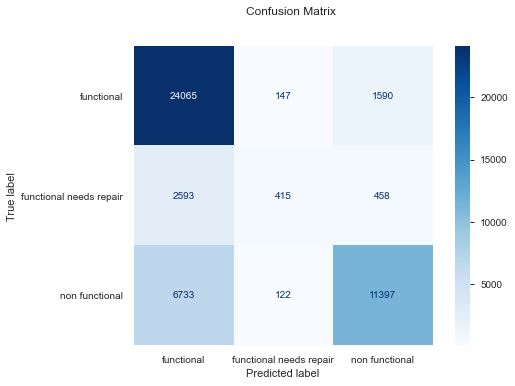

In [111]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots()

fig.suptitle("Confusion Matrix")

plot_confusion_matrix(rfc, X_train_ohe, y_train, ax=ax, cmap="Blues");

### How does KNN do on this?

In [101]:
knc = KNeighborsClassifier()

knc.fit(X_train_ohe, y_train)

KNeighborsClassifier()

In [102]:
knc_preds = knc.predict(X_train_ohe)

In [103]:
display_scores(y_train, knc_preds, model_name="KNearestNeighbors")

Model: KNearestNeighbors
Recall: 0.704229797979798
Accuracy: 0.704229797979798
F1-Score: 0.704229797979798
Precision: 0.704229797979798
Classification Report:
                          precision    recall  f1-score   support

             functional       0.71      0.83      0.77     25802
functional needs repair       0.27      0.13      0.18      3466
         non functional       0.73      0.63      0.68     18252

               accuracy                           0.70     47520
              macro avg       0.57      0.53      0.54     47520
           weighted avg       0.69      0.70      0.69     47520

Confusion Matrix:
 [[21524   743  3535]
 [ 2323   450   693]
 [ 6278   483 11491]]
--------------------------------------------------------------------------------


<function __main__.display_scores(true, preds, model_name)>

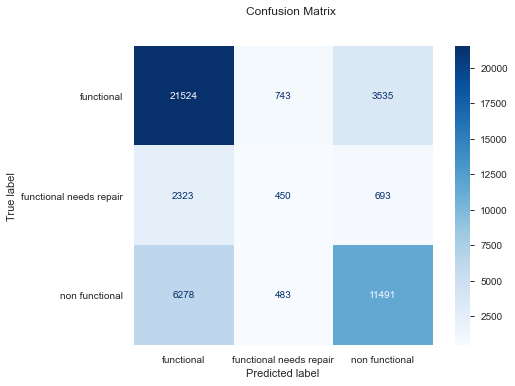

In [105]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots()

fig.suptitle("Confusion Matrix")

plot_confusion_matrix(knc, X_train_ohe, y_train, ax=ax, cmap="Blues");